# 🤖 Nemotron-VLA: Vision-Language-Action Model with NVIDIA Foundation Models<div align="center">**A fully-functional VLA powered by NVIDIA Nemotron & RADIO***Vision: NVIDIA RADIO · Language: NVIDIA Nemotron Nano 9B v2 · Action: Diffusion Policy*[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](#)</div>---## Overview**Nemotron-VLA** is a Vision-Language-Action model that uses NVIDIA's foundation models as its backbone:| Modality | Model | Role | Parameters | Trainable? ||----------|-------|------|------------|------------|| 🖼️ Vision | **NVIDIA RADIO** | Image feature extractor | ~0.4-0.7B | ❄️ Frozen || 📝 Language | **NVIDIA Nemotron Nano 9B v2** | Text instruction encoder | ~9B | ❄️ Frozen || 🦾 Action | **Diffusion Policy Head** | Action generation | ~0.5M | 🔥 Trained || 🔀 Fusion | **Cross-Attention Module** | Multi-modal fusion | ~0.3M | 🔥 Trained |### Architecture```  NVIDIA RADIO (ViT)    Nemotron Nano 9B v2    Robot State       │                       │                    │   [frozen]                [frozen]             [trainable]       │                       │                    │  Vision Proj ──────── Text Proj ──────── State Encoder       │                       │                    │       └───────────┬───────────┘────────────────────┘                   │          Cross-Attention Fusion                   │         Diffusion Policy Head                   │              Robot Actions```### Training StrategyTo fit everything on an **A100 40GB** Colab GPU:1. **Collect** expert demonstrations from MetaWorld2. **Precompute** RADIO vision features (load → extract → unload)3. **Precompute** Nemotron text embeddings (load → extract → unload)4. **Train** only the lightweight fusion + diffusion modules> 💡 **Key insight:** By precomputing embeddings from the frozen NVIDIA models, we only need ~1M trainable parameters during the training loop, making it extremely memory efficient!

---## 1. 🔧 Setup & InstallationFirst, let's install all required dependencies. This cell handles MetaWorld, MuJoCo, NVIDIA models, and rendering on Colab.

In [2]:
# # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# # 1.1 Setup MuJoCo headless rendering (no sudo required)
# # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# import os, glob

# def find_lib(name_patterns, search_dirs=None):
#     """Search for a shared library across common system paths."""
#     if search_dirs is None:
#         search_dirs = [
#             "/usr/lib/x86_64-linux-gnu",
#             "/usr/lib/x86_64-linux-gnu/mesa",
#             "/usr/lib/x86_64-linux-gnu/nvidia",
#             "/usr/lib64",
#             "/usr/lib",
#             "/usr/local/lib",
#             os.path.expanduser("~/miniconda3/lib"),
#             os.path.expanduser("~/anaconda3/lib"),
#             "/opt/conda/lib",
#         ]
#         # Also scan conda env libs
#         search_dirs += glob.glob(os.path.expanduser("~/.conda/envs/*/lib"))
#     for d in search_dirs:
#         for expanded in glob.glob(d):
#             if not os.path.isdir(expanded):
#                 continue
#             for pattern in name_patterns:
#                 matches = glob.glob(os.path.join(expanded, pattern))
#                 if matches:
#                     return matches[0], expanded
#     return None, None

# # ── Locate EGL or OSMesa on the system ──
# egl_path, egl_dir = find_lib(["libEGL.so", "libEGL.so.1", "libEGL.so.*"])
# osmesa_path, osmesa_dir = find_lib(["libOSMesa.so", "libOSMesa.so.8", "libOSMesa.so.*"])

# print("Scanning for rendering libraries...")
# print(f"   EGL:    {egl_path or 'not found'}")
# print(f"   OSMesa: {osmesa_path or 'not found'}")

# # ── If neither found, install via conda (no sudo) ──
# if not egl_path and not osmesa_path:
#     print("\nNo rendering libs found, installing via conda...")
#     os.system("conda install -y -q -c conda-forge mesalib glew 2>/dev/null || pip install -q PyOpenGL")
#     egl_path, egl_dir = find_lib(["libEGL.so", "libEGL.so.1", "libEGL.so.*"])
#     osmesa_path, osmesa_dir = find_lib(["libOSMesa.so", "libOSMesa.so.8", "libOSMesa.so.*"])
#     print(f"   After install - EGL: {egl_path}, OSMesa: {osmesa_path}")

# # ── Add library directory to LD_LIBRARY_PATH ──
# lib_dir = egl_dir or osmesa_dir
# if lib_dir:
#     current = os.environ.get("LD_LIBRARY_PATH", "")
#     if lib_dir not in current:
#         os.environ["LD_LIBRARY_PATH"] = f"{lib_dir}:{current}"
#         print(f"\n   Added to LD_LIBRARY_PATH: {lib_dir}")

# # ── Select backend ──
# if egl_path:
#     os.environ["MUJOCO_GL"] = "egl"
#     print(f"\n✅ Using EGL backend: {egl_path}")
# elif osmesa_path:
#     os.environ["MUJOCO_GL"] = "osmesa"
#     os.environ["PYOPENGL_PLATFORM"] = "osmesa"
#     print(f"\n✅ Using OSMesa backend: {osmesa_path}")
# else:
#     os.environ["MUJOCO_GL"] = "egl"
#     print("\n⚠️  Defaulting to EGL - MuJoCo may resolve it internally")


In [3]:
# # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# # 1.2 Python packages
# # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# !pip install -q \
#     torch torchvision \
#     transformers accelerate \
#     mujoco \
#     gymnasium metaworld \
#     imageio[ffmpeg] imageio-ffmpeg \
#     matplotlib tqdm \
#     open_clip_torch timm

# # For Nemotron's hybrid Mamba-2 architecture
# !pip install -q causal-conv1d mamba-ssm

# print("\n✅ All Python packages installed")


In [1]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 1.3 Verify GPU & MuJoCo rendering
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
import os, torch

os.environ["MUJOCO_GL"] = "egl"

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available:  {torch.cuda.is_available()}")
if torch.cuda.is_available():
    gpu = torch.cuda.get_device_name(0)
    mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU:             {gpu}")
    print(f"GPU Memory:      {mem:.1f} GB")

print(f"\nMUJOCO_GL:       {os.environ.get('MUJOCO_GL', 'not set')}")
print(f"LD_LIBRARY_PATH: {os.environ.get('LD_LIBRARY_PATH', 'not set')[:120]}...")

import mujoco
print(f"MuJoCo version:  {mujoco.__version__}")

# Quick smoke test — create a tiny model, render one frame
xml = '<mujoco><worldbody><light pos="0 0 1"/><geom type="sphere" size="0.1"/></worldbody></mujoco>'
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height=64, width=64)
mujoco.mj_forward(model, data)
renderer.update_scene(data)
frame = renderer.render()
renderer.close()
print(f"Render test:     ✅ rendered {frame.shape} frame")

print("\n🚀 Everything works!")

PyTorch version: 2.10.0+cu128
CUDA available:  True
GPU:             NVIDIA A100-SXM4-40GB
GPU Memory:      42.4 GB

MUJOCO_GL:       egl
LD_LIBRARY_PATH: /shared/EL9/explorer/cuda/12.8.0/lib64:/shared/EL9/explorer/anaconda3/2024.06/lib:/shared/EL9/explorer/nodejs/v22.11.0/l...
MuJoCo version:  3.4.0
Render test:     ✅ rendered (64, 64, 3) frame

🚀 Everything works!


## 2. 📁 Write Helper ModulesWe organize the code into three helper files
- **`env.py`** — MetaWorld environment wrapper & data collection
- **`models.py`** — RADIO encoder, Nemotron encoder, fusion, diffusion head, full VLA
- **`utils.py`** — Dataset, training loop, evaluation, visualization

In [2]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Create project directories
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
import os
for d in ["data", "checkpoints", "videos", "embeddings"]:
    os.makedirs(d, exist_ok=True)
print("📂 Project directories created")


📂 Project directories created


## 3. 🎮 Collect Expert Demonstrations
We use MetaWorld's built-in scripted expert policy for `push-v3` to collect demonstration trajectories. Each transition includes:- **Image**: RGB observation from the `corner2` camera- **State**: 39-dim robot proprioceptive state- **Action**: 4-dim action (x, y, z, gripper)- **Instruction**: "push the object to the goal"

In [3]:
from env import collect_demonstrations
import numpy as np
import os

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Collect demonstrations
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
DATA_PATH = "data/push_v3_demos.npz"

if os.path.exists(DATA_PATH):
    print(f"✅ Dataset already exists at {DATA_PATH}, skipping collection")
else:
    print("🎮 Collecting expert demonstrations...")
    data = collect_demonstrations(
        env_name="push-v3",
        camera_name="corner2",
        seed=42,
        num_episodes=100,
        max_steps=150,
        instruction="push the object to the goal",
    )

    np.savez_compressed(
        DATA_PATH,
        images=data["images"],
        states=data["states"],
        actions=data["actions"],
        instruction=data["instruction"],
    )
    print(f"\n💾 Dataset saved to {DATA_PATH}")


✅ Dataset already exists at data/push_v3_demos.npz, skipping collection


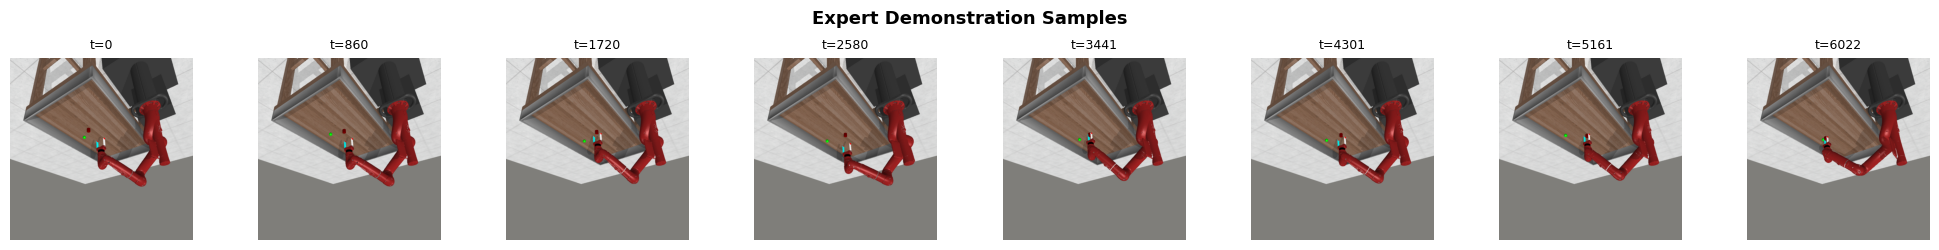

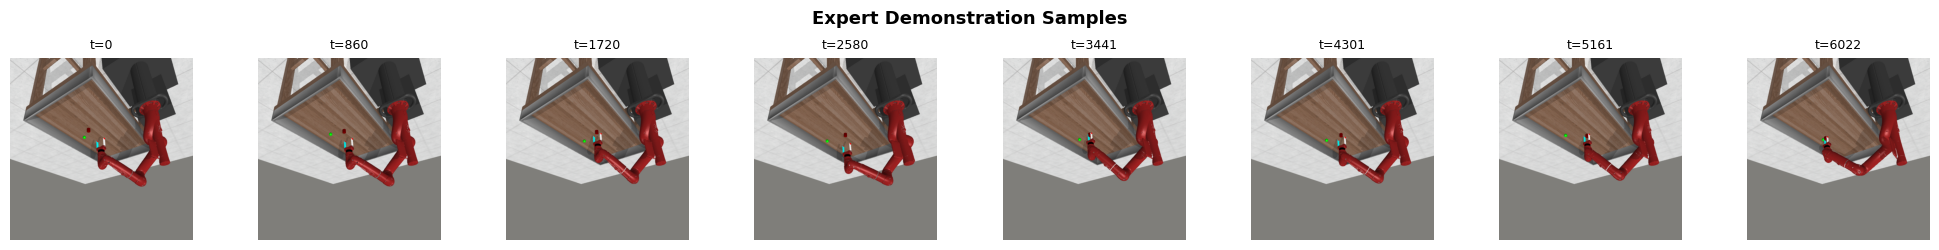

In [4]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Visualize some demonstration frames
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
from utils import display_sample_frames

display_sample_frames(DATA_PATH, n_frames=8)


---## 4. 🧠 Precompute NVIDIA Model EmbeddingsThis is the key memory management strategy:1. **Load NVIDIA RADIO** → extract vision features for ALL images → unload2. **Load NVIDIA Nemotron 9B** → extract text embedding → unload3. **Save** all precomputed embeddings to diskThis way, during training we only need the small trainable components in GPU memory!> ⏱️ This step takes ~5-10 minutes (downloading models + forward passes)

In [7]:
# Collect multi-task data
from collect_multitask import get_available_tasks, collect_multitask_demonstrations, merge_multitask_datasets

tasks = get_available_tasks() # available tasks

# Option A: Collect a curated subset
selected_tasks = [
    "push-v3",
    "reach-v3",
    "door-open-v3",
    "drawer-close-v3",
    "window-open-v3",
    "button-press-v3",
    "pick-place-v3",
    "faucet-open-v3",
]

summary = collect_multitask_demonstrations(
    task_list=selected_tasks,
    episodes_per_task=30,
    max_steps=150,
    output_dir="data/multitask",
)

# Option B: Collect ALL tasks (takes longer, ~50 tasks × 30 eps)
# summary = collect_multitask_demonstrations(episodes_per_task=30)

Found 50 tasks with expert policies + instructions

[1/8] push-v3
  Instruction: "push the object to the goal"


/home/pandya.kei/.conda/envs/nemotron-vla/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:35: UserWarning: WARN: A Box observation space maximum and minimum values are equal.
  logger.warn("A Box observation space maximum and minimum values are equal.")
/home/pandya.kei/.conda/envs/nemotron-vla/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/pandya.kei/.conda/envs/nemotron-vla/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/pandya.kei/.conda/envs/nemotron-vla/lib/python3.10/site-packages/metaworld/policies/policy.py:49: UserWarning: Constant(s) may be too high. Environments clip response to [-1, 

  ✅ 1821 transitions, 30/30 success (100%)
  💾 Saved to data/multitask/push-v3.npz

[2/8] reach-v3
  Instruction: "reach to the target position"
  ✅ 1341 transitions, 30/30 success (100%)
  💾 Saved to data/multitask/reach-v3.npz

[3/8] door-open-v3
  Instruction: "open the door"
  ✅ 2431 transitions, 29/30 success (97%)
  💾 Saved to data/multitask/door-open-v3.npz

[4/8] drawer-close-v3
  Instruction: "close the drawer"
  ✅ 2355 transitions, 30/30 success (100%)
  💾 Saved to data/multitask/drawer-close-v3.npz

[5/8] window-open-v3
  Instruction: "open the window"
  ✅ 2639 transitions, 30/30 success (100%)
  💾 Saved to data/multitask/window-open-v3.npz

[6/8] button-press-v3
  Instruction: "press the button from the top"
  ✅ 1785 transitions, 30/30 success (100%)
  💾 Saved to data/multitask/button-press-v3.npz

[7/8] pick-place-v3
  Instruction: "pick up the object and place it at the goal"
  ✅ 1553 transitions, 30/30 success (100%)
  💾 Saved to data/multitask/pick-place-v3.npz

[8/8] f

In [11]:
merge_multitask_datasets(
    data_dir="data/multitask",
    output_path="data/multitask_merged.npz",
)

Merging 8 task datasets...
  button-press-v3: 1785 transitions — "press the button from the top"
  door-open-v3: 2431 transitions — "open the door"
  drawer-close-v3: 2355 transitions — "close the drawer"
  faucet-open-v3: 1771 transitions — "open the faucet"
  pick-place-v3: 1553 transitions — "pick up the object and place it at the goal"
  push-v3: 1821 transitions — "push the object to the goal"
  reach-v3: 1341 transitions — "reach to the target position"
  window-open-v3: 2639 transitions — "open the window"

💾 Merged dataset saved to data/multitask_merged.npz
   Total transitions: 15696
   Unique tasks: 8
   Images shape: (15696, 480, 480, 3)


{'total_transitions': 15696,
 'num_tasks': 8,
 'output_path': 'data/multitask_merged.npz'}

### 4.1 Extract RADIO Vision Features[NVIDIA RADIO (AM-RADIO)](https://huggingface.co/nvidia/RADIO) is a multi-teacher distilled vision model that combines knowledge from CLIP, DINOv2, and SAM into a single efficient backbone. We use it as a frozen feature extractor.

In [12]:
import importlib
import models
importlib.reload(models)
from models import load_radio_model, extract_radio_features, unload_model

In [13]:
import torch
import numpy as np
from models import load_radio_model, extract_radio_features, unload_model

EMBEDDINGS_PATH = "embeddings/multitask_precomputed.npz"
DATA_PATH = "data/multitask_merged.npz"

if os.path.exists(EMBEDDINGS_PATH):
    print(f"✅ Embeddings already exist, skipping")
else:
    data = np.load(DATA_PATH, allow_pickle=True)
    images = data["images"]
    instructions = data["instructions"]  # per-transition instruction strings

    # Unique instructions for Nemotron (no need to embed duplicates)
    unique_instructions = list(set(instructions))
    print(f"Loaded {len(images)} images, {len(unique_instructions)} unique instructions")

    # ── Step 1: RADIO Vision Features ──
    print("\n" + "="*60)
    print("STEP 1: NVIDIA RADIO Vision Features")
    print("="*60)
    radio_model, radio_dim = load_radio_model(device="cuda")
    radio_features = extract_radio_features(radio_model, images, device="cuda", batch_size=64)
    unload_model(radio_model)

    # ── Step 2: Nemotron Text Embeddings (one per unique instruction) ──
    print("\n" + "="*60)
    print("STEP 2: NVIDIA Nemotron Text Embeddings")
    print("="*60)
    from models import load_nemotron_model, extract_nemotron_embedding

    nemotron_model, tokenizer, nemotron_dim = load_nemotron_model(device="cuda")

    instruction_to_embedding = {}
    for i, instr in enumerate(unique_instructions):
        print(f"  [{i+1}/{len(unique_instructions)}] \"{instr}\"")
        emb = extract_nemotron_embedding(nemotron_model, tokenizer, instr, device="cuda")
        instruction_to_embedding[instr] = emb

    unload_model(nemotron_model)
    del tokenizer

    # Build per-transition embedding array by mapping each instruction
    nemotron_embeddings = np.stack([
        instruction_to_embedding[instr] for instr in instructions
    ], axis=0)  # (N, nemotron_dim)

    print(f"\nNemotron embeddings: {nemotron_embeddings.shape}")

    # ── Save ──
    np.savez_compressed(
        EMBEDDINGS_PATH,
        radio_features=radio_features,
        nemotron_embeddings=nemotron_embeddings,  # (N, nemotron_dim) — per transition
        radio_dim=radio_dim,
        nemotron_dim=nemotron_dim,
    )
    print(f"\n💾 Saved to {EMBEDDINGS_PATH}")

Loaded 15696 images, 8 unique instructions

STEP 1: NVIDIA RADIO Vision Features
📸 Loading NVIDIA RADIO vision encoder...


Using cache found in /home/pandya.kei/.cache/torch/hub/NVlabs_RADIO_main
/home/pandya.kei/.conda/envs/nemotron-vla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   ✅ RADIO loaded — summary dim: 2304
   RADIO features: 64/15696
   RADIO features: 704/15696
   RADIO features: 1344/15696
   RADIO features: 1984/15696
   RADIO features: 2624/15696
   RADIO features: 3264/15696
   RADIO features: 3904/15696
   RADIO features: 4544/15696
   RADIO features: 5184/15696
   RADIO features: 5824/15696
   RADIO features: 6464/15696
   RADIO features: 7104/15696
   RADIO features: 7744/15696
   RADIO features: 8384/15696
   RADIO features: 9024/15696
   RADIO features: 9664/15696
   RADIO features: 10304/15696
   RADIO features: 10944/15696
   RADIO features: 11584/15696
   RADIO features: 12224/15696
   RADIO features: 12864/15696
   RADIO features: 13504/15696
   RADIO features: 14144/15696
   RADIO features: 14784/15696
   RADIO features: 15424/15696
   ✅ Extracted RADIO features: (15696, 2304)
   🗑️  Model unloaded, GPU memory freed

STEP 2: NVIDIA Nemotron Text Embeddings
🧠 Loading nvidia/NVIDIA-Nemotron-Nano-9B-v2 for text encoding...
   (This may ta

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:34<00:00,  8.74s/it]
NemotronH requires an initialized `NemotronHHybridDynamicCache` to return a cache. None was provided, so no cache will be returned.


   ✅ Nemotron loaded — hidden dim: 4480
  [1/8] "open the window"
   ✅ Nemotron text embedding: (4480,)
  [2/8] "push the object to the goal"
   ✅ Nemotron text embedding: (4480,)
  [3/8] "close the drawer"
   ✅ Nemotron text embedding: (4480,)
  [4/8] "reach to the target position"
   ✅ Nemotron text embedding: (4480,)
  [5/8] "open the door"
   ✅ Nemotron text embedding: (4480,)
  [6/8] "pick up the object and place it at the goal"
   ✅ Nemotron text embedding: (4480,)
  [7/8] "open the faucet"
   ✅ Nemotron text embedding: (4480,)
  [8/8] "press the button from the top"
   ✅ Nemotron text embedding: (4480,)
   🗑️  Model unloaded, GPU memory freed

Nemotron embeddings: (15696, 4480)

💾 Saved to embeddings/multitask_precomputed.npz


### 4.2 Extract Nemotron Text Embedding
[NVIDIA Nemotron Nano 9B v2](https://huggingface.co/nvidia/NVIDIA-Nemotron-Nano-9B-v2) uses a hybrid **Mamba-2 + Transformer** architecture for high-throughput language understanding. We extract a text embedding by mean-pooling the last hidden layer.Since we use a single instruction for all episodes, we only need to compute this embedding **once**.

In [14]:
if not os.path.exists(EMBEDDINGS_PATH):
    # ── Step 2: Nemotron Text Embedding ──
    print("\n" + "="*60)
    print("STEP 2: NVIDIA Nemotron Nano 9B Text Embedding")
    print("="*60)

    from models import load_nemotron_model, extract_nemotron_embedding

    nemotron_model, tokenizer, nemotron_dim = load_nemotron_model(device="cuda")
    nemotron_embedding = extract_nemotron_embedding(
        nemotron_model, tokenizer, instruction, device="cuda"
    )
    unload_model(nemotron_model)
    del tokenizer

    print(f"\n🧠 Nemotron embedding shape: {nemotron_embedding.shape}")
    print(f"   GPU memory after unload: {torch.cuda.memory_allocated()/1e9:.2f} GB")

    # ── Save all embeddings ──
    np.savez_compressed(
        EMBEDDINGS_PATH,
        radio_features=radio_features,
        nemotron_embedding=nemotron_embedding,
        radio_dim=radio_dim,
        nemotron_dim=nemotron_dim,
    )
    print(f"\n💾 All embeddings saved to {EMBEDDINGS_PATH}")
    print(f"   RADIO features:    {radio_features.shape}")
    print(f"   Nemotron embedding: {nemotron_embedding.shape}")


## 5. 🏋️ Train Nemotron-VLANow we train only the lightweight components
**Vision projection**: Linear layer mapping RADIO features → d_model- **Text projection**: Linear layer mapping Nemotron embedding → d_model- **State encoder**: 2-layer MLP for robot state- **Cross-attention fusion**: Multi-head attention over modality tokens- **Diffusion policy head**: DDPM-based action generationTotal trainable parameters: **~0.8M** — trains fast even without the A100 being fully utilized!

In [14]:
import torch
from models import NemotronVLA, count_parameters
from utils import NemotronVLADataset, train_nemotron_vla

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Load dataset with precomputed embeddings
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
dataset = NemotronVLADataset(
    data_path="data/push_v3_demos.npz",
    embeddings_path="embeddings/precomputed.npz",
)

# Load embedding dimensions
emb = np.load("embeddings/precomputed.npz", allow_pickle=True)
radio_dim = int(emb["radio_dim"])
nemotron_dim = int(emb["nemotron_dim"])

# Infer state and action dims from data
raw = np.load("data/push_v3_demos.npz", allow_pickle=True)
state_dim = raw["states"].shape[1]
action_dim = raw["actions"].shape[1]

print(f"\n🔧 Model Configuration:")
print(f"   RADIO dim:    {radio_dim}")
print(f"   Nemotron dim: {nemotron_dim}")
print(f"   State dim:    {state_dim}")
print(f"   Action dim:   {action_dim}")


📦 Dataset loaded: 6023 samples
   vision features: (6023, 2304)
   text embedding:  (4480,)
   states:          (6023, 39)
   actions:         (6023, 4)

🔧 Model Configuration:
   RADIO dim:    2304
   Nemotron dim: 4480
   State dim:    39
   Action dim:   4


In [15]:
from models import NemotronVLA, count_parameters
from utils import train_nemotron_vla
from torch.utils.data import Dataset, DataLoader

class MultiTaskVLADataset(Dataset):
    """Dataset with per-transition text embeddings for multi-task training."""
    def __init__(self, data_path, embeddings_path):
        raw = np.load(data_path, allow_pickle=True)
        self.states = raw["states"].astype(np.float32)
        self.actions = raw["actions"].astype(np.float32)

        emb = np.load(embeddings_path, allow_pickle=True)
        self.vision_features = emb["radio_features"].astype(np.float32)
        self.text_embeddings = emb["nemotron_embeddings"].astype(np.float32)  # (N, dim)

        print(f"📦 Multi-task dataset: {len(self)} samples")
        print(f"   vision:  {self.vision_features.shape}")
        print(f"   text:    {self.text_embeddings.shape}")
        print(f"   states:  {self.states.shape}")
        print(f"   actions: {self.actions.shape}")

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.vision_features[idx]),
            torch.from_numpy(self.text_embeddings[idx]),  # unique per transition
            torch.from_numpy(self.states[idx]),
            torch.from_numpy(self.actions[idx]),
        )

dataset = MultiTaskVLADataset(
    data_path="data/multitask_merged.npz",
    embeddings_path="embeddings/multitask_precomputed.npz",
)

emb = np.load("embeddings/multitask_precomputed.npz")
radio_dim = int(emb["radio_dim"])
nemotron_dim = int(emb["nemotron_dim"])
state_dim = dataset.states.shape[1]
action_dim = dataset.actions.shape[1]

📦 Multi-task dataset: 15696 samples
   vision:  (15696, 2304)
   text:    (15696, 4480)
   states:  (15696, 39)
   actions: (15696, 4)


In [16]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Create Nemotron-VLA model
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
model = NemotronVLA(
    radio_dim=radio_dim,
    nemotron_dim=nemotron_dim,
    state_dim=state_dim,
    action_dim=action_dim,
    d_model=256,             # internal representation dim
    n_heads=4,               # cross-attention heads
    diffusion_T=20,          # diffusion denoising steps
)

total_params, trainable_params = count_parameters(model)
print(f"\n📊 Nemotron-VLA Model:")
print(f"   Total parameters:     {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Memory footprint:     ~{trainable_params * 4 / 1e6:.1f} MB (float32)")



📊 Nemotron-VLA Model:
   Total parameters:     2,783,492
   Trainable parameters: 2,783,492
   Memory footprint:     ~11.1 MB (float32)


In [17]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Train!
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
losses = train_nemotron_vla(
    model=model,
    dataset=dataset,
    epochs=80,               # training epochs
    batch_size=128,          # batch size (can increase on A100)
    lr=3e-4,                 # learning rate
    weight_decay=1e-5,       # AdamW weight decay
    device="cuda",
    save_path="checkpoints/nemotron_vla.pt",
    log_interval=5,          # print every 5 epochs
)



🏋️ Training Nemotron-VLA for 80 epochs
   batch_size=128, lr=0.0003, samples=15696
   batches/epoch=122
------------------------------------------------------------
   Epoch   1/80 | loss=0.978387 | best=0.978387 | lr=3.00e-04
   Epoch   5/80 | loss=0.645640 | best=0.645640 | lr=2.97e-04
   Epoch  10/80 | loss=0.491397 | best=0.491397 | lr=2.89e-04
   Epoch  15/80 | loss=0.408453 | best=0.408453 | lr=2.75e-04
   Epoch  20/80 | loss=0.349935 | best=0.349935 | lr=2.57e-04
   Epoch  25/80 | loss=0.297697 | best=0.297697 | lr=2.34e-04
   Epoch  30/80 | loss=0.268115 | best=0.265331 | lr=2.08e-04
   Epoch  35/80 | loss=0.233463 | best=0.233463 | lr=1.80e-04
   Epoch  40/80 | loss=0.224060 | best=0.223194 | lr=1.52e-04
   Epoch  45/80 | loss=0.193590 | best=0.193590 | lr=1.23e-04
   Epoch  50/80 | loss=0.179060 | best=0.179060 | lr=9.47e-05
   Epoch  55/80 | loss=0.159567 | best=0.159567 | lr=6.90e-05
   Epoch  60/80 | loss=0.144930 | best=0.144930 | lr=4.65e-05
   Epoch  65/80 | loss=0.132

   📈 Loss plot saved to checkpoints/loss_curve.png


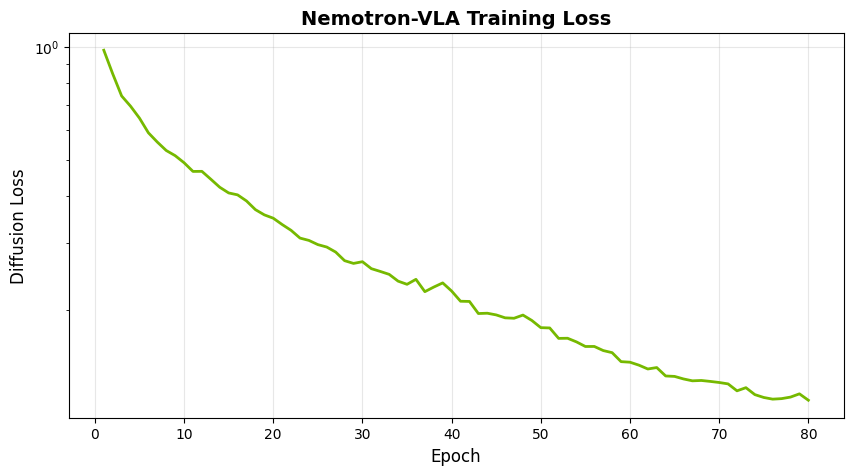

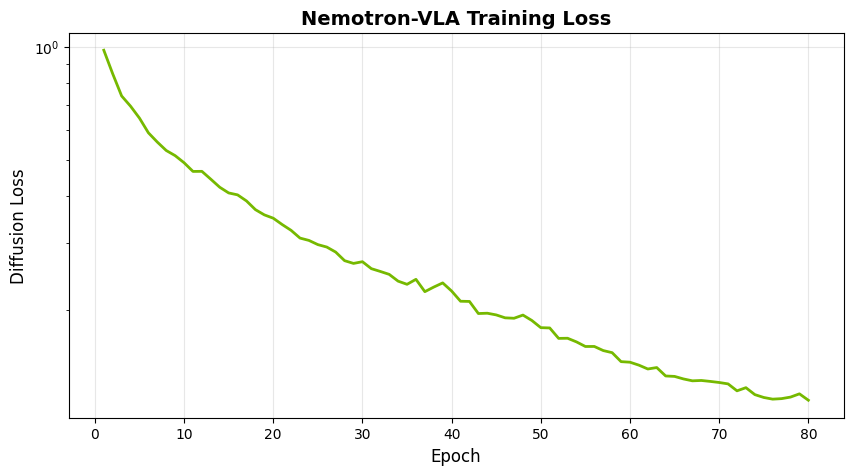

In [18]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Plot training loss
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
from utils import plot_training_loss

plot_training_loss(losses, save_path="checkpoints/loss_curve.png")


## 6. 🎯 Evaluate Nemotron-VLA
Now we test the trained model in the MetaWorld `push-v3` environment. During inference:- **RADIO** runs online to process each new camera frame- **Nemotron** embedding is cached (loaded from disk)- The **fusion + diffusion head** generates actions in real-time

In [19]:
import torch
import numpy as np
from models import load_radio_model
from utils import load_checkpoint, evaluate_nemotron_vla

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Load trained model and RADIO for online inference
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
device = "cuda"

vla_model = load_checkpoint("checkpoints/nemotron_vla.pt", device=device)
# radio_model, _ = load_radio_model(device=device, dtype=torch.float16)
radio_model, _ = load_radio_model(device=device)

emb = np.load("embeddings/precomputed.npz", allow_pickle=True)
text_embedding = emb["nemotron_embedding"]

print(f"\n✅ All models loaded for inference")
print(f"   GPU memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")


✅ Loaded checkpoint from checkpoints/nemotron_vla.pt
   Epoch: 79, Loss: 0.114843
📸 Loading NVIDIA RADIO vision encoder...


Using cache found in /home/pandya.kei/.cache/torch/hub/NVlabs_RADIO_main


   ✅ RADIO loaded — summary dim: 2304

✅ All models loaded for inference
   GPU memory: 18.62 GB


In [20]:
import os
print(f"MUJOCO_GL: {os.environ.get('MUJOCO_GL', 'NOT SET')}")

# Test 1: Can we create the environment without crashing?
from env import MetaWorldMT1Wrapper
print("Creating environment...")
env = MetaWorldMT1Wrapper(env_name="push-v3", camera_name="corner2", seed=42)
print(f"  env created, state_dim={env.state_dim}")

# Test 2: Can we render a frame?
img, state, info = env.reset()
print(f"  rendered frame: {img.shape}")
env.close()
print("✅ Environment works")

# Test 3: Check GPU memory
import torch
allocated = torch.cuda.memory_allocated() / 1e9
reserved = torch.cuda.memory_reserved() / 1e9
total = torch.cuda.get_device_properties(0).total_memory / 1e9
print(f"\nGPU memory: {allocated:.1f}GB used / {total:.1f}GB total")

MUJOCO_GL: egl
Creating environment...
  env created, state_dim=39
  rendered frame: (480, 480, 3)
✅ Environment works

GPU memory: 18.6GB used / 42.4GB total


/home/pandya.kei/.conda/envs/nemotron-vla/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:35: UserWarning: WARN: A Box observation space maximum and minimum values are equal.
  logger.warn("A Box observation space maximum and minimum values are equal.")
/home/pandya.kei/.conda/envs/nemotron-vla/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [21]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Run evaluation
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
results = evaluate_nemotron_vla(
    model=vla_model,
    radio_model=radio_model,
    text_embedding=text_embedding,
    env_name="push-v3",
    camera_name="corner2",
    seed=42,
    num_episodes=10,
    max_steps=150,
    device=device,
    save_video=True,
    video_dir="videos",
)



🎯 Evaluating Nemotron-VLA on push-v3
   episodes=10, max_steps=150
------------------------------------------------------------


/home/pandya.kei/.conda/envs/nemotron-vla/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


   Episode 1/10: reward=982.11, steps=150, ✅ SUCCESS
   Episode 2/10: reward=1100.83, steps=150, ✅ SUCCESS
   Episode 3/10: reward=1016.16, steps=150, ✅ SUCCESS
   Episode 4/10: reward=1017.92, steps=150, ✅ SUCCESS
   Episode 5/10: reward=962.03, steps=150, ✅ SUCCESS
   Episode 6/10: reward=1063.15, steps=150, ✅ SUCCESS
   Episode 7/10: reward=1010.23, steps=150, ✅ SUCCESS
   Episode 8/10: reward=1003.02, steps=150, ✅ SUCCESS
   Episode 9/10: reward=1038.96, steps=150, ✅ SUCCESS
   Episode 10/10: reward=975.77, steps=150, ✅ SUCCESS
------------------------------------------------------------
📊 Results:
   Mean reward:  1017.02 ± 39.78
   Success rate: 100.0%


In [28]:
import torch, numpy as np, os, imageio
import torchvision.transforms as T
from env import MetaWorldMT1Wrapper
from models import load_radio_model, load_nemotron_model, extract_nemotron_embedding, unload_model
from utils import load_checkpoint

device = "cuda"

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Step 1: Pre-encode ALL instructions with Nemotron (no other models loaded)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# tasks_to_run = [
#     ("push-v3",         "push the object to the goal"),
#     ("door-open-v3",    "open the door"),
#     ("drawer-close-v3", "close the drawer"),
#     ("faucet-open-v3",  "open the faucet"),
#     ("push-v3",         "move the red block forward"),  # novel instruction
# ]

tasks_to_run = [
    ("button-press-v3", "press the button from the top"),
    ("door-open-v3", "open the door"),
    ("drawer-close-v3", "close the drawer"),
    ("faucet-open-v3", "open the faucet"),
    ("pick-place-v3", "pick up the object and place it at the goal"),
    ("push-v3", "push the object to the goal"),
    ("reach-v3", "reach to the target position"),
    ("window-open-v3", "open the window"),
    ("push-v3", "move the red block forward"), # novel instruction variant
]


"""
Merging 8 task datasets...
  button-press-v3: 1785 transitions — "press the button from the top"
  door-open-v3: 2431 transitions — "open the door"
  drawer-close-v3: 2355 transitions — "close the drawer"
  faucet-open-v3: 1771 transitions — "open the faucet"
  pick-place-v3: 1553 transitions — "pick up the object and place it at the goal"
  push-v3: 1821 transitions — "push the object to the goal"
  reach-v3: 1341 transitions — "reach to the target position"
  window-open-v3: 2639 transitions — "open the window"
"""

# Unload RADIO + VLA first to free GPU for Nemotron
del vla_model, radio_model
torch.cuda.empty_cache()

print("🧠 Pre-encoding all instructions with Nemotron...")
nemotron_model, tokenizer, _ = load_nemotron_model(device=device)

cached_embeddings = {}
for env_name, instruction in tasks_to_run:
    if instruction not in cached_embeddings:
        print(f"  → \"{instruction}\"")
        cached_embeddings[instruction] = extract_nemotron_embedding(
            nemotron_model, tokenizer, instruction, device=device
        )

# Free all 18GB
unload_model(nemotron_model)
del nemotron_model, tokenizer
torch.cuda.empty_cache()

print(f"✅ Encoded {len(cached_embeddings)} instructions, Nemotron unloaded\n")


# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Step 2: Load VLA + RADIO (small models, ~2GB together)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
vla_model = load_checkpoint("checkpoints/nemotron_vla.pt", device=device)
radio_model, _ = load_radio_model(device=device)

transform = T.Compose([
    T.ToPILImage(),
    T.Resize(224, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
])
conditioner = getattr(radio_model, "input_conditioner", None)


# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Step 3: Run episodes using cached embeddings
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
def run_task(env_name, instruction, max_steps=150, camera_name="corner2", seed=42):
    """Run a task using pre-cached text embedding."""

    text_emb = cached_embeddings[instruction]
    txt_tensor = torch.from_numpy(text_emb).float().unsqueeze(0).to(device)

    print(f"\n🌍 {env_name}: \"{instruction}\"")
    env = MetaWorldMT1Wrapper(
        env_name=env_name, seed=seed,
        render_mode="rgb_array", camera_name=camera_name,
    )

    img, state, info = env.reset()
    frames = [img.copy()]
    ep_reward = 0.0
    success = False

    vla_model.eval()
    radio_model.eval()

    for step in range(max_steps):
        img_t = transform(img).unsqueeze(0).to(device=device, dtype=torch.float32)
        if conditioner is not None:
            img_t = conditioner(img_t)
        with torch.no_grad():
            vis_emb = radio_model(img_t)[0].float()
            state_t = torch.from_numpy(state).float().unsqueeze(0).to(device)
            action_t = vla_model.act(vis_emb, txt_tensor, state_t)

        img, state, reward, done, info = env.step(action_t.squeeze(0).cpu().numpy())
        ep_reward += reward
        frames.append(img.copy())
        if int(info.get("success", 0)) == 1:
            success = True
        if done:
            break

    env.close()

    os.makedirs("videos", exist_ok=True)
    safe_name = instruction.replace(" ", "_")[:40]
    video_path = f"videos/{env_name}_{safe_name}.mp4"
    with imageio.get_writer(video_path, fps=20) as writer:
        for f in frames:
            writer.append_data(f)

    status = "✅ SUCCESS" if success else "❌ FAIL"
    print(f"  {status} | reward={ep_reward:.2f} | steps={step+1} | {video_path}")
    return {"reward": ep_reward, "success": success, "steps": step+1, "video_path": video_path}


# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Run all tasks
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
results = []
for env_name, instruction in tasks_to_run:
    r = run_task(env_name, instruction)
    results.append(r)

🧠 Pre-encoding all instructions with Nemotron...
🧠 Loading nvidia/NVIDIA-Nemotron-Nano-9B-v2 for text encoding...
   (This may take a few minutes to download ~18GB)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


   ✅ Nemotron loaded — hidden dim: 4480
  → "press the button from the top"
   ✅ Nemotron text embedding: (4480,)
  → "open the door"
   ✅ Nemotron text embedding: (4480,)
  → "close the drawer"
   ✅ Nemotron text embedding: (4480,)
  → "open the faucet"
   ✅ Nemotron text embedding: (4480,)
  → "pick up the object and place it at the goal"
   ✅ Nemotron text embedding: (4480,)
  → "push the object to the goal"
   ✅ Nemotron text embedding: (4480,)
  → "reach to the target position"
   ✅ Nemotron text embedding: (4480,)
  → "open the window"
   ✅ Nemotron text embedding: (4480,)
  → "move the red block forward"
   ✅ Nemotron text embedding: (4480,)
   🗑️  Model unloaded, GPU memory freed
✅ Encoded 9 instructions, Nemotron unloaded

✅ Loaded checkpoint from checkpoints/nemotron_vla.pt
   Epoch: 79, Loss: 0.114843
📸 Loading NVIDIA RADIO vision encoder...


Using cache found in /home/pandya.kei/.cache/torch/hub/NVlabs_RADIO_main


   ✅ RADIO loaded — summary dim: 2304

🌍 button-press-v3: "press the button from the top"
  ✅ SUCCESS | reward=128.85 | steps=150 | videos/button-press-v3_press_the_button_from_the_top.mp4

🌍 door-open-v3: "open the door"
  ✅ SUCCESS | reward=873.03 | steps=150 | videos/door-open-v3_open_the_door.mp4

🌍 drawer-close-v3: "close the drawer"
  ✅ SUCCESS | reward=1053.25 | steps=150 | videos/drawer-close-v3_close_the_drawer.mp4

🌍 faucet-open-v3: "open the faucet"
  ✅ SUCCESS | reward=1130.34 | steps=150 | videos/faucet-open-v3_open_the_faucet.mp4

🌍 pick-place-v3: "pick up the object and place it at the goal"
  ✅ SUCCESS | reward=967.81 | steps=150 | videos/pick-place-v3_pick_up_the_object_and_place_it_at_the_g.mp4

🌍 push-v3: "push the object to the goal"
  ✅ SUCCESS | reward=974.14 | steps=150 | videos/push-v3_push_the_object_to_the_goal.mp4

🌍 reach-v3: "reach to the target position"
  ✅ SUCCESS | reward=1337.27 | steps=150 | videos/reach-v3_reach_to_the_target_position.mp4

🌍 window-o

In [22]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Display a recorded video
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
from IPython.display import HTML
from base64 import b64encode
import glob

video_files = sorted(glob.glob("videos/*.mp4"))
if video_files:
    # Display the first video
    video_path = video_files[0]
    with open(video_path, "rb") as f:
        video_data = b64encode(f.read()).decode("ascii")

    display(HTML(f'''
    <h3>🎬 Nemotron-VLA: {os.path.basename(video_path)}</h3>
    <video width="480" controls autoplay loop>
        <source src="data:video/mp4;base64,{video_data}" type="video/mp4">
    </video>
    '''))
else:
    print("No videos found in videos/ directory")


## 7. 📊 Summary & Next Steps
### What We Built**Nemotron-VLA** 
— a Vision-Language-Action model for robot manipulation using NVIDIA's foundation models:
| Component | Model | Source |
|-----------|-------|--------|
| Vision Encoder | NVIDIA RADIO | [HuggingFace](https://huggingface.co/nvidia/RADIO) |
| Language Encoder | NVIDIA Nemotron Nano 9B v2 | [HuggingFace](https://huggingface.co/nvidia/NVIDIA-Nemotron-Nano-9B-v2) |
| Fusion Module | Cross-Attention (custom) | Trained from scratch |
| Action Head | DDPM Diffusion Policy (custom) | Trained from scratch |

### Key Design Decisions
1. **Precomputed embeddings**: We extract features from RADIO and Nemotron offline, enabling training on A100 40GB
2. **Cross-attention fusion**: Upgraded from mini-VLA's MLP concatenation to multi-head self-attention over modality tokens
3. **Deeper diffusion head**: 3-layer noise prediction network with LayerNorm for better action quality
4. **Memory efficiency**: Only ~0.8M trainable parameters, entire training fits in <4GB GPU memory

### Possible Extensions
- 🔄 **Multi-task**: Train on multiple MetaWorld tasks (MT10/MT50)
- 🗣️ **Arbitrary instructions**: Load Nemotron at inference for free-form text
- 📈 **Action chunking**: Predict sequences of future actions
- 🔬 **LoRA fine-tuning**: Fine-tune RADIO or Nemotron with LoRA for domain adaptation
- 🤖 **Real robot**: Deploy on physical hardware with camera input

*Built with ❤️ using NVIDIA Nemotron & RADIO foundation models*